In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

In [48]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-08 19:50:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.1’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.009s  

2025-10-08 19:50:54 (88.1 MB/s) - ‘car_fuel_efficiency.csv.1’ saved [874188/874188]



In [49]:
df = pd.read_csv("car_fuel_efficiency.csv")
df

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
...,...,...,...,...,...,...,...,...,...,...,...
9699,140,5.0,164.0,2981.107371,17.3,2013,Europe,Diesel,Front-wheel drive,NaN,15.101802
9700,180,NaN,154.0,2439.525729,15.0,2004,USA,Gasoline,All-wheel drive,0.0,17.962326
9701,220,2.0,138.0,2583.471318,15.1,2008,USA,Diesel,All-wheel drive,-1.0,17.186587
9702,230,4.0,177.0,2905.527390,19.4,2011,USA,Diesel,Front-wheel drive,1.0,15.331551


In [50]:
#Needed Columns
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


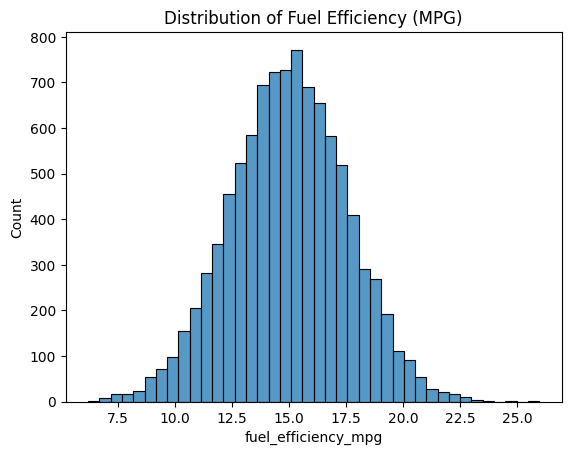

In [51]:
#EDA
df.describe()

#Checking for long tail
sns.histplot(df.fuel_efficiency_mpg, bins=40)
plt.title('Distribution of Fuel Efficiency (MPG)')
plt.show()

In [70]:
#Question 1

df.isnull().sum()
#It can be seen that it's only the horsepower column that has missing values

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [71]:
#Question 2

median_hp = df["horsepower"].median()
median_hp

np.float64(149.0)

In [55]:
#Question 3

#This function will be used to split the data into train, validation and test data

def split_data(df, seed = 42):
    np.random.seed(seed)
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    
    n = len(df)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)
    
    return df_train, df_val, df_test

In [56]:
df_train, df_val, df_test = split_data(df, seed = 42)

In [65]:
# This function will be used to prepare the data matrices

#The mean computed on the training data alone
mean_hp = df_train['horsepower'].mean()

def prepare_X(df, fill_with='mean', mean_hp=None):
    df_num = df.copy()
    if fill_with == '0':
        df_num = df_num.fillna(0)
    elif fill_with == 'mean':
        df_num['horsepower'] = df_num['horsepower'].fillna(mean_hp)
    X = df_num[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].values     #Features matrix
    y = df_num['fuel_efficiency_mpg'].values       #Target variable
    return X, y

In [72]:
#Comparing filling Nan valuews with 0 vs filling with mean
scores = {}

for method in ['0', 'mean']:
    X_train, y_train = prepare_X(df_train, fill_with=method, mean_hp=mean_hp)
    X_val, y_val = prepare_X(df_val, fill_with=method, mean_hp=mean_hp)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores[method] = rmse

print("RMSE with fill=0:", round(scores['0'], 2))
print("RMSE with fill=mean:", round(scores['mean'], 2))
print("Best method:", 'mean' if scores['mean'] < scores['0'] else '0')

RMSE with fill=0: 0.51
RMSE with fill=mean: 0.46
Best method: mean


In [78]:
# Question 4

X_train, y_train = prepare_X(df_train, fill_with='0')
X_val, y_val = prepare_X(df_val, fill_with='0')

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_values:
    model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
    rmse_scores[r] = round(rmse, 2)

print(rmse_scores)
best_r = min(rmse_scores, key=rmse_scores.get)
best_r

{0: 0.51, 0.01: 0.51, 0.1: 0.51, 1: 0.51, 5: 0.51, 10: 0.51, 100: 0.51}


0

In [76]:
#Question 5

rmse_per_seed = []

for seed in range(10):
    df_train, df_val, df_test = split_data(df, seed)
    X_train, y_train = prepare_X(df_train, fill_with='0')
    X_val, y_val = prepare_X(df_val, fill_with='0')
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_per_seed.append(rmse)

std_rmse = np.std(rmse_per_seed)
round(std_rmse, 3)

np.float64(0.007)

In [77]:
#Question 6

df_train, df_val, df_test = split_data(df, seed=9)
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
X_full_train, y_full_train = prepare_X(df_full_train, fill_with='0')
X_test, y_test = prepare_X(df_test, fill_with='0')

model = Ridge(alpha=0.001)
model.fit(X_full_train, y_full_train)
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

round(rmse_test, 3)

np.float64(0.515)